# Patient Selection

The purpose of this notebook is to generate a list of patient ICU stays that meet the following criteria:
- patient is at least 16 years old.
- ICU stay lasts at least 24 hours.
- patient was mechanically ventilated at least once.

Two pandas DataFrames are created and saved in **"data/patients.npy"**.

The column names in ***patients*** are:
- **subject_id** - patient identifier.
- **hadm_id** - hospital admission identifier.
- **icustay_id** - ICU admission identifier.
- **gender, dob, age** - self-explanatory.
- **admittime, dischtime** - time of hospital admission and discharge.
- **intime, outtime** - time of ICU admission and discharge.
- **los** - length of ICU stay in days.
- **diagnosis** - free text diagnosis usually assigned by the admitting clinician.
- **hospital_expire_flag** - whether the patient died during that hospital stay or not.
- **ventnum** - the number of times they were placed on mechanical ventilation.

The column names in ***mech_vent*** are:
- **icustay_id** - ICU admission identifier.
- **ventnum** - a counter for the number of instances of mechanical ventilation for that ICU stay (1 is the patient's first time on a ventilator, 2 is the second, etc.).
- **starttime, endtime** - time at which the patient was intubated and extubated.
- **duration_hours** - the duration of that instance of mechanical ventilation.

In [1]:
# Import libraries
import numpy as np
import pandas as pd
import psycopg2
import getpass
import os.path
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# Load the database connection details
_data = np.load('data/db_details.npy', allow_pickle=True).tolist()
db_details = _data['db_details']
user = db_details['user']
host = db_details['host']
port = db_details['port']
dbname = db_details['dbname']
schema = db_details['schema']
    
# Connect to the database
conn = psycopg2.connect(dbname=dbname, user=user, host=host, port=port, password=getpass.getpass(prompt='Password:'.format(user)))
cur = conn.cursor()
cur.execute('SET search_path TO {}'.format(schema))
conn.commit()

Password: ··········


In [3]:
# Load the appropriate query
query = open('queries/icu_patients.sql', 'r')

# Store the result of the query as a pandas dataframe
icu = pd.read_sql_query(query.read(), conn)
query.close()

In [4]:
# Show some sample data
icu.head()

,subject_id,hadm_id,icustay_id,gender,dob,age,admittime,dischtime,intime,outtime,los,diagnosis,hospital_expire_flag
0,268,110404,280836,F,2132-02-21,65.98,2198-02-11 13:40:00,2198-02-18 03:55:00,2198-02-14 23:27:38,2198-02-18 05:26:11,3.2490,DYSPNEA,1
1,270,188028,220345,M,2048-05-26,80.08,2128-06-23 18:26:00,2128-06-27 12:31:00,2128-06-24 15:05:20,2128-06-27 12:32:29,2.8939,CAROTID STENOSIS\CAROTID ANGIOGRAM AND STENT,0
2,271,173727,249196,F,2074-11-30,45.68,2120-08-07 18:56:00,2120-08-20 16:00:00,2120-08-07 23:12:42,2120-08-10 00:39:04,2.0600,GALLSTONE PANCREATITIS,0
3,273,158689,241507,M,2107-08-10,33.69,2141-04-19 06:11:00,2141-04-20 17:00:00,2141-04-19 06:12:05,2141-04-20 17:52:11,1.4862,POLYSUBSTANCE OVERDOSE,0
4,274,130546,254851,M,2048-05-18,66.11,2114-06-28 22:16:00,2114-07-12 15:30:00,2114-06-28 22:28:44,2114-07-07 18:01:16,8.8143,SUBARACHNOID HEMORRHAGE,0


In [5]:
# Print some statistics about the patient population
print('No. of patients: {}'.format(len(np.unique(icu['subject_id']))))
print('No. of hospital admissions: {}'.format(len(np.unique(icu['hadm_id']))))
print('No. of ICU admissions: {}'.format(len(np.unique(icu['icustay_id']))))

No. of patients: 46476
No. of hospital admissions: 57786
No. of ICU admissions: 61532


In [6]:
# Remove any patients under 16 years old
adult_icu = icu[icu['age']>=16]
print('Removed {} patients under 16 years old (corresponding to {} hospital admissions and {} ICU stays)'.format(len(np.unique(icu['subject_id']))-len(np.unique(adult_icu['subject_id'])), len(np.unique(icu['hadm_id']))-len(np.unique(adult_icu['hadm_id'])), len(np.unique(icu['icustay_id']))-len(np.unique(adult_icu['icustay_id']))))

Removed 7879 patients under 16 years old (corresponding to 8001 hospital admissions and 8109 ICU stays)


In [7]:
# Remove any patients with ICU stays under 24 hours
adult_24h_icu = adult_icu[adult_icu['los']>=1]
print('Removed {} patients with ICU stays lasting less than 24 hours (corresponding to {} hospital admissions and {} ICU stays)'.format(len(np.unique(adult_icu['subject_id']))-len(np.unique(adult_24h_icu['subject_id'])), len(np.unique(adult_icu['hadm_id']))-len(np.unique(adult_24h_icu['hadm_id'])), len(np.unique(adult_icu['icustay_id']))-len(np.unique(adult_24h_icu['icustay_id']))))

Removed 4972 patients with ICU stays lasting less than 24 hours (corresponding to 7222 hospital admissions and 8102 ICU stays)


In [8]:
# Load the mechanical ventilation query
query = open('queries/mechanical_ventilation.sql', 'r')

# Store the result of the query as a pandas dataframe
mech_vent = pd.read_sql_query(query.read(), conn)
query.close()

In [9]:
# Show some sample data
mech_vent.head()

,icustay_id,ventnum,starttime,endtime,duration_hours
0,200003.0,1,2199-08-03 18:00:00,2199-08-07 13:00:00,91.000000
1,200006.0,1,2159-09-03 13:00:00,2159-09-04 03:50:00,14.833333
2,200009.0,1,2189-11-30 18:10:00,2189-12-01 10:00:00,15.833333
3,200011.0,1,2188-08-06 01:00:00,2188-08-06 04:00:00,3.000000
4,200014.0,1,2105-02-16 23:15:00,2105-02-17 18:00:00,18.750000


In [10]:
# Remove missing ICU stay IDs
num_missing = sum(mech_vent['icustay_id'].isna())
mech_vent = mech_vent.dropna(subset=['icustay_id'])
print("Removed {} rows with missing ICU stay IDs".format(num_missing))

Removed 34 rows with missing ICU stay IDs


In [11]:
# Select ventilation information only for patients who meet our criteria
mech_vent_patients = mech_vent[mech_vent['icustay_id'].isin(adult_24h_icu['icustay_id'])]
print("Removed {} ICU stays that don't meet the criteria above (corresponding to {} instances of mechanical ventilation)".format(len(np.unique(mech_vent['icustay_id']))-len(np.unique(mech_vent_patients['icustay_id'])), len(mech_vent['icustay_id'])-len(mech_vent_patients['icustay_id'])))

Removed 3494 ICU stays that don't meet the criteria above (corresponding to 4164 instances of mechanical ventilation)


In [12]:
# Remove patients who were not mechanically ventilated
adult_24h_icu_mv = adult_24h_icu[adult_24h_icu['icustay_id'].isin(mech_vent_patients['icustay_id'])]
print('Removed {} ICU stays where mechanical ventilation was not used'.format(len(np.unique(adult_24h_icu['icustay_id']))-len(np.unique(adult_24h_icu_mv['icustay_id']))))

Removed 22014 ICU stays where mechanical ventilation was not used


In [13]:
# Add a column describing the number of times a patient was ventilated
adult_24h_icu_mv = adult_24h_icu_mv.merge(mech_vent_patients.groupby(['icustay_id']).max()['ventnum'], on='icustay_id')

In [14]:
# Show some sample data for adult first ICU admission
adult_24h_icu_mv.head()

,subject_id,hadm_id,icustay_id,gender,dob,age,admittime,dischtime,intime,outtime,los,diagnosis,hospital_expire_flag,ventnum
0,268,110404,280836,F,2132-02-21,65.98,2198-02-11 13:40:00,2198-02-18 03:55:00,2198-02-14 23:27:38,2198-02-18 05:26:11,3.2490,DYSPNEA,1,1
1,273,158689,241507,M,2107-08-10,33.69,2141-04-19 06:11:00,2141-04-20 17:00:00,2141-04-19 06:12:05,2141-04-20 17:52:11,1.4862,POLYSUBSTANCE OVERDOSE,0,1
2,275,129886,219649,M,2088-08-07,82.16,2170-10-06 03:09:00,2170-10-19 15:35:00,2170-10-07 11:28:53,2170-10-14 14:38:07,7.1314,UROSEPSIS-CHANGE IN MENTAL STATUS,1,1
3,281,111199,257572,F,2041-10-12,60.02,2101-10-18 04:42:00,2101-10-25 19:10:00,2101-10-18 04:45:22,2101-10-25 22:29:25,7.7389,"PNEUMONIA,HYPONATREMIA",1,2
4,283,109185,231490,M,2090-09-05,75.93,2166-08-12 22:02:00,2166-09-12 14:41:00,2166-08-12 22:03:26,2166-09-12 14:41:42,30.6932,PNEUMONIA,0,2


In [15]:
# Print some statistics about the processed patient population
print("No. of instances of mechanical ventilation: {}".format(len(mech_vent_patients['icustay_id'])))
print('No. of patients: {}'.format(len(np.unique(adult_24h_icu_mv['subject_id']))))
print('No. of hospital admissions: {}'.format(len(np.unique(adult_24h_icu_mv['hadm_id']))))
print('No. of ICU admissions: {}'.format(len(np.unique(adult_24h_icu_mv['icustay_id']))))

No. of instances of mechanical ventilation: 34259
No. of patients: 20011
No. of hospital admissions: 22525
No. of ICU admissions: 23307


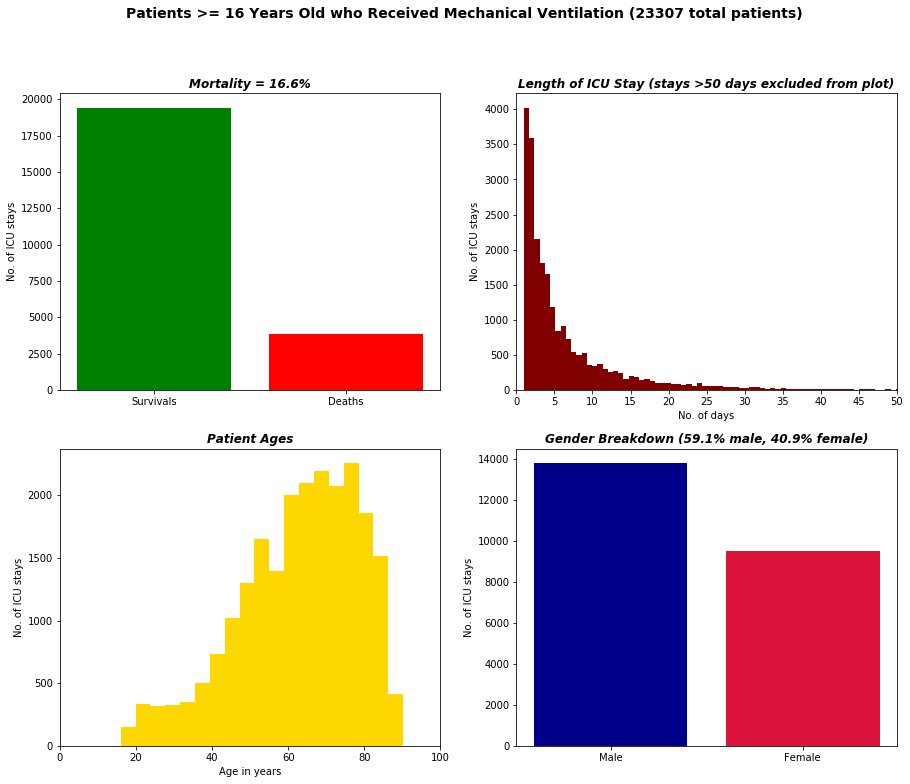

In [20]:
# Visualise mortality rate,length of ICU stay, age and gender
fig, axs = plt.subplots(2, 2, figsize=(15,12))
fig.suptitle('Patients >= 16 Years Old who Received Mechanical Ventilation ({} total patients)'.format(len(adult_24h_icu_mv)), weight='semibold', fontsize=14)

# Plot the mortality
axs[0,0].bar(x=['Survivals','Deaths'], height=[len(adult_24h_icu_mv[adult_24h_icu_mv['hospital_expire_flag']==0]),len(adult_24h_icu_mv[adult_24h_icu_mv['hospital_expire_flag']==1])], color=['g','r'])
axs[0,0].set_title('Mortality = {:.1f}%'.format(100*len(adult_24h_icu_mv[adult_24h_icu_mv['hospital_expire_flag']==1])/len(adult_24h_icu_mv)), style='italic', weight='semibold')
axs[0,0].set_ylabel('No. of ICU stays')

# Plot the length of stay
axs[0,1].hist(x=adult_24h_icu_mv['los'], bins=250, color='maroon')
axs[0,1].set_title('Length of ICU Stay (stays >50 days excluded from plot)', style='italic', weight='semibold')
axs[0,1].set_xlim([0,50])
axs[0,1].set_xticks(range(0,51,5))
axs[0,1].set_xlabel('No. of days')
axs[0,1].set_ylabel('No. of ICU stays')

# Plot the patient ages
axs[1,0].hist(x=adult_24h_icu_mv['age'].astype('int64'), bins=75, color='gold')
axs[1,0].set_title('Patient Ages', style='italic', weight='semibold')
axs[1,0].set_xlim([0,100])
axs[1,0].set_xlabel('Age in years')
axs[1,0].set_ylabel('No. of ICU stays')

# Plot the gender breakdown
axs[1,1].bar(x=['Male','Female'], height=[sum(adult_24h_icu_mv['gender']=='M'),sum(adult_24h_icu_mv['gender']=='F')], color=['darkblue','crimson'])
axs[1,1].set_title('Gender Breakdown ({:.1f}% male, {:.1f}% female)'.format(100*sum(adult_24h_icu_mv['gender']=='M')/len(adult_24h_icu_mv), 100*sum(adult_24h_icu_mv['gender']=='F')/len(adult_24h_icu_mv)), style='italic', weight='semibold')
axs[1,1].set_ylabel('No. of ICU stays')

# Save the plot
plt.savefig('plots/patients.png');

In [21]:
# Sort patients by subject_id, then hadm_id and icustay_id
adult_24h_icu_mv.sort_values(by=['subject_id', 'hadm_id', 'icustay_id'])

# Save to patients.npy
if not os.path.exists('./data'):
    os.makedirs('./data')

tosave = {'patients': adult_24h_icu_mv, 'mech_vent': mech_vent_patients}
np.save('data/patients.npy',tosave)
print("Saved!")

Saved!
